In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 

In [2]:
def p_next_to(positions, room, object1_index, object2_index, side1 = None, side2 = None):
    """ The function next_to ensures that two objects are next to each other in a room. 
        If side1 is given, the specific side of object1 will be used. If side2 is given, 
        the specific side of object2 will be used. E.g. the 'front' of the chair should be next to the 'back' of the desk. 
        
        Args:
        room: rectangular Room object
        object1: Object object
        object2: Object object
        side: string, one of 'top' or 'back', 'bottom' or 'front', 'left', 'right', defines which side of the object to check
    """
    val = 0

    obj1 = room.moving_objects[object1_index]
    obj2 = room.moving_objects[object2_index]

    x1, y1, theta1 = positions[3*object1_index:3*object1_index+3]
    x2, y2, theta2 = positions[3*object2_index:3*object2_index+3]
    cs1 = np.array(corners(x1, y1, theta1, obj1.width, obj1.length)) # TL, TR, BR, BL
    cs2 = np.array(corners(x2, y2, theta2, obj2.width, obj2.length)) # TL, TR, BR, BL

    if side1: 
        if side1 == 'top' or side1 == 'back':
            point1, point2 = cs1[0], cs1[1]
        elif side1 == 'bottom' or side1 == 'front':
            point1, point2 = cs1[2], cs1[3]
        elif side1 == 'left':
            point1, point2 = cs1[0], cs1[3]
        elif side1 == 'right':
            point1, point2 = cs1[1], cs1[2]
        else:
            print("Invalid side for object1, continuing with no side.")
            return p_next_to(positions, room, object1_index, object2_index, side2 = side2)
    if side2: 
        if side2 == 'top' or side2 == 'back':
            point3, point4 = cs2[0], cs2[1]
        elif side2 == 'bottom' or side2 == 'front':
            point3, point4 = cs2[2], cs2[3]
        elif side2 == 'left':
            point3, point4 = cs2[0], cs2[3]
        elif side2 == 'right':
            point3, point4 = cs2[1], cs2[2]
        else:
            print("Invalid side for object2, continuing with no side.")
            return p_next_to(positions, room, object1_index, object2_index, side1 = side1)
    if side1 and side2:

        ### if two sides are given, we want the two sides to be parallel, as well as the two objects to be close to each other
        ### Want it to not matter if the centers are close per se, more that the sides are close (perpendicular distance between the two lines?)
        direction1 = np.array([point2[0] - point1[0], point2[1] - point1[1]]) # side1
        direction2 = np.array([point4[0] - point3[0], point4[1] - point3[1]]) # side2

        angle_diff = np.dot(direction1, direction2) / (np.linalg.norm(direction1) * np.linalg.norm(direction2))
        if angle_diff >= 0:
            val += max(0.0, 0.95 - angle_diff)**2
        else:
            val += max(0.0, -0.95 - angle_diff)**2

        if np.linalg.norm(direction1) > np.linalg.norm(direction2):
            point5 = np.array([(point3[0] + point4[0]) / 2, (point3[1] + point4[1]) / 2]) # point on the shorter side
            direction3 = np.array([point5[0] - point1[0], point5[1] - point1[1]])
            direction4 = np.array([point5[0] - point2[0], point5[1] - point2[1]])
            t = np.dot(direction1, direction3)/np.linalg.norm(direction1)
            direction5 = direction1
        else: 
            point5 = np.array([(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]) # point on the shorter side
            direction3 = np.array([point5[0] - point3[0], point5[1] - point3[1]])
            direction4 = np.array([point5[0] - point4[0], point5[1] - point4[1]])
            t = np.dot(direction2, direction3)/np.linalg.norm(direction2)
            direction5 = direction2
        if t < 0: 
            val += np.linalg.norm(direction3)**2 + (t)**2
        if t > 1: 
            val += np.linalg.norm(direction4)**2 + (t - 1)**2
        else: 
            distance = np.linalg.norm(np.cross(direction5, direction3)) / np.linalg.norm(direction5)
            val += distance**2
    
    if side1 and not side2:
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = p_next_to(positions, room, object1_index, object2_index, side1 = side1, side2 = sides[i])
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist
                
        # mid_point = (point1 + point2)/2 
        # ## Want to minimise the distance of this side from the center??? of object2
        # side_dist = (np.linalg.norm(point1 - np.array([x2, y2])) + np.linalg.norm(point2 - np.array([x2, y2])) + np.linalg.norm(mid_point - np.array([x2, y2])))/3
        # other_dists = np.sqrt(np.sum((cs1 - np.array([x2, y2]))**2, axis = 0))
        # val = sum(np.clip(side_dist - other_dists, 0.0, np.inf)**2)
        return val 
    if side2 and not side1:     
        min_side_dist = np.inf
        sides = ['front', 'back', 'left', 'right']
        for i in range(4): 
            side_value = p_next_to(positions, room, object1_index, object2_index, side1 = sides[i], side2 = side2)
            min_side_dist = min(min_side_dist, side_value)
        val += min_side_dist

        return val 
    if not side2 and not side1: 
        ### If no sides are given, we want the two objects to be close to each other as possible from any direction
        ### Want the distance between the two objects to be minimized but also to not be overlapping 

        distance = np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))
        val += distance**2

    return val 

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
0 8.912216482395118 Optimization terminated successfully
1 0.0962186089870482 Optimization terminated successfully
2 22.83562355545408 Optimization terminated successfully
3 15.190239545169513 Optimization terminated successfully
4 0.5264427493553585 Optimization terminated successfully
5 31.96867327931111 Optimization terminated successfully
6 25.21305563654904 Optimization terminated successfully
7 23.12944662696318 Optimization terminated successfully
8 26.25459220505738 Optimization terminated successfully
9 11.156248872122369 Optimization terminated successfully
10 15.843934236775532 Optimization terminated successfully
11 11.18765891081736 Optimization terminated successfully
12 11.01325945414387 Optimization terminated successfully
13 18.892629736687933 Optimization terminated successfully
14 18.465392057

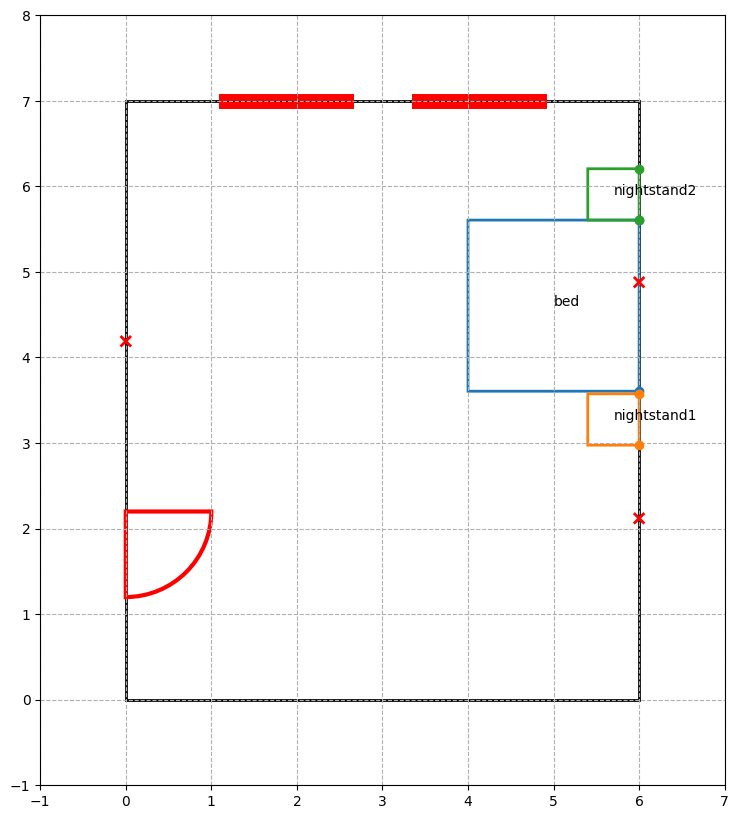

In [9]:
large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(large_bedroom, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(large_bedroom, 'bed', 2, 2, 'sleeping', 0)
create_moving_object(large_bedroom, 'nightstand1', 0.6, 0.6, 'dressing', 0)
create_moving_object(large_bedroom, 'nightstand2', 0.6, 0.6, 'dressing', 1)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_next_to_wall(positions, room, 1, side = 'back')
    output += ind_next_to_wall(positions, room, 2, side = 'back')
    output += p_next_to(positions, room, 0, 1, side1 = 'left', side2 = 'right')
    output += p_next_to(positions, room, 0, 2, side1 = 'right', side2 = 'left')
    output += p_parallel_aligned(positions, room, 1, 2, ['bed', 0])
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += p_parallel_aligned(positions, room, 1, 2, ['bed', 0])
    output += ind_central(positions, room, 0)

    output += ind_accessible(positions, room, 0, ['front'])  # bed
    output += ind_accessible(positions, room, 1, ['front'])  # nightstand1
    output += ind_accessible(positions, room, 2, ['front'])  # nightstand2

    output += ind_aligned(positions, room)
    output += 5*ind_no_overlap(positions, room)
    output += 5*ind_in_bounds(positions, room)

    return output

bounds = Bounds([0] * 3 * len(large_bedroom.moving_objects), [large_bedroom.width, large_bedroom.length, 2*np.pi] * len(large_bedroom.moving_objects))
options = {'maxiter': 500, 'ftol': 1e-6}

repeats = 15
positions = np.zeros((repeats, 3*len(large_bedroom.moving_objects)))
for j in range(repeats):
    for i in range(len(large_bedroom.moving_objects)): 
        positions[j, 3*i] = np.random.uniform(0, large_bedroom.width)
        positions[j, 3*i + 1] = np.random.uniform(0, large_bedroom.length)
        positions[j, 3*i + 2] = np.random.uniform(0, 2*np.pi)

min_fun = np.Inf
for j in range(repeats):
    res = minimize(optimize_primary_objects, positions[j, :], args = (large_bedroom), method = 'SLSQP', options = options) # constraints = cons
    print(j, res.fun, res.message)
    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if min_fun < len(large_bedroom.moving_objects)*1e-2:
        break
    
for i in range(len(large_bedroom.moving_objects)): 
    large_bedroom.moving_objects[i].position = best_res.x[3*i:3*i + 3] 
large_bedroom.draw() 

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
0 7.5110581995607415 Optimization terminated successfully 7.5110581995607415
1 8.950022626616164 Optimization terminated successfully 8.950022626616164
2 24.780617218317794 Optimization terminated successfully 24.780617218317794
3 30.409306397672946 Optimization terminated successfully 30.409306397672946
4 9.554599772407236 Optimization terminated successfully 9.554599772407236
5 7.439738889868902 Optimization terminated successfully 7.439738889868902
6 4.4938041538254625 Optimization terminated successfully 4.4938041538254625
7 9.148931783412783 Optimization terminated successfully 9.148931783412783
8 33.13043017050693 Optimization termi

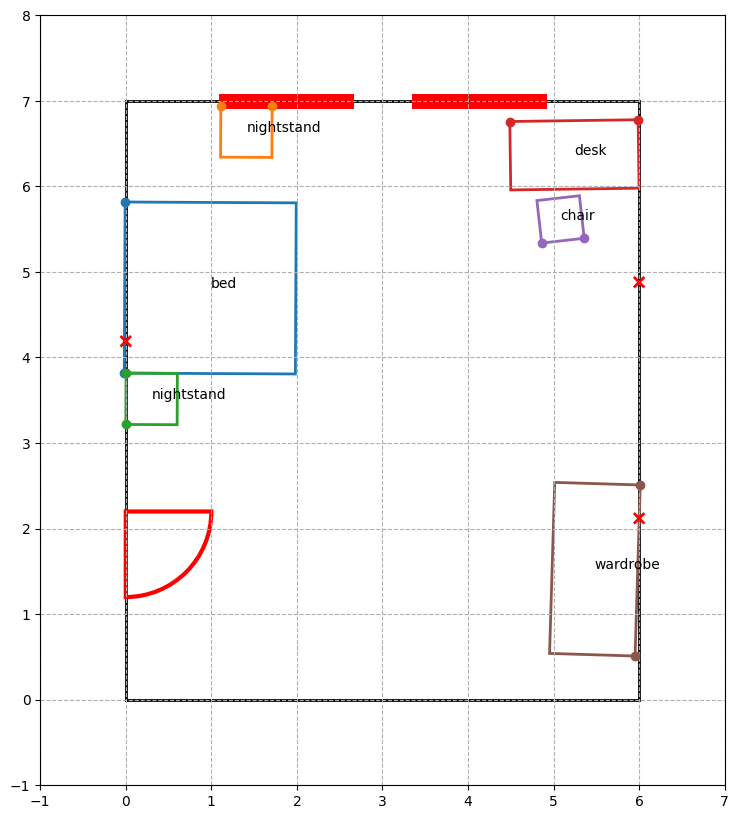

4.4938041538254625 4.4938041538254625


In [3]:
#from Pairwise import * 

large_bedroom = create_room(6, 7)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(large_bedroom, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(large_bedroom, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(large_bedroom, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(large_bedroom, 'bed', 2, 2, 'sleeping', 0)
create_moving_object(large_bedroom, 'nightstand', 0.6, 0.6, 'dressing', 1)
create_moving_object(large_bedroom, 'nightstand', 0.6, 0.6, 'dressing', 2)
create_moving_object(large_bedroom, 'desk', 1.5, 0.8, 'work/study', 3)
create_moving_object(large_bedroom, 'chair', 0.5, 0.5, 'work/study', 4)
create_moving_object(large_bedroom, 'wardrobe', 2, 1, 'storage', 5)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'back')  # bed
    output += ind_next_to_wall(positions, room, 1, side = 'back')
    output += ind_next_to_wall(positions, room, 2, side = 'back')
    output += p_next_to(positions, room, 0, 1, side1 = 'left', side2 = 'right')
    output += p_next_to(positions, room, 0, 2, side1 = 'right', side2 = 'left')
    output += p_aligned(positions, room, 1, 2, ['bed', 0])
    output += ind_close_to_fixed_object(positions, room, 0, 'socket', side = 'back')
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'door')
    output += p_parallel_aligned(positions, room, 1, 2, ['bed', 0])
    output += ind_central(positions, room, 0)

    output += ind_next_to_wall(positions, room, 3, 'back')  # desk
    output += ind_close_to_fixed_object(positions, room, 3, 'socket', side = 'back', max_dist = 2)
    output += ind_close_to_fixed_object(positions, room, 3, 'window', max_dist = 2)
    output += p_away_from(positions, room, 3, 0)
    output += p_next_to(positions, room, 3, 4, side1 = 'front', side2 = 'front')
    output += p_facing(positions, room, 3, 4, both = True)
    output += ind_accessible(positions, room, 4, ['back'])

    output += ind_next_to_wall(positions, room, 5, 'back')  # wardrobe
    output += ind_not_block_fixed_object(positions, room, 5, 'window')
    output += ind_accessible(positions, room, 5, ['front'])

    output += ind_aligned(positions, room)
    output += 5*ind_no_overlap(positions, room)
    output += 5*ind_in_bounds(positions, room)

    return output

bounds = Bounds([0] * 3 * len(large_bedroom.moving_objects), [large_bedroom.width, large_bedroom.length, 2*np.pi] * len(large_bedroom.moving_objects))
options = {'maxiter': 500, 'ftol': 1e-6}

max_iters = 25
min_fun = np.Inf
iters = 0
while min_fun > 1:
    positions = np.zeros(3*len(large_bedroom.moving_objects))
    for i in range(len(large_bedroom.moving_objects)): 
        positions[3*i] = np.random.uniform(0, large_bedroom.width)
        positions[3*i + 1] = np.random.uniform(0, large_bedroom.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(optimize_primary_objects, positions, args = (large_bedroom), method = 'SLSQP', options = options) # constraints = cons
    print(iters, res.fun, res.message, optimize_primary_objects(res.x, large_bedroom))
    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if iters == max_iters: 
        print("Max number of iterations reached.")
        break 
    iters += 1
    
for i in range(len(large_bedroom.moving_objects)): 
    large_bedroom.moving_objects[i].position = best_res.x[3*i:3*i + 3] 

large_bedroom.draw() 

In [2]:
def p_perpendicular_aligned(positions, room, object1_index, object2_index, center_object_index = None):
    """ The function p_perpendicular_aligned ensures that two objects are aligned in a room perpendicularly. 
        If center is given, the objects will be aligned about that point. For example, 
        a sofa and chair might be aligned perpendicularly about a coffee table or a side table. Or a chair at the head of the table 
        might be aligned perpendicularly with the chairs closest to it on the sides of the table. 

        
        Args:

        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        object1_index: int, index of object1 in the room
        object2_index: int, index of object2 in the room
        center_object_index: int, index of object in room.moving_objects to be used as the pivot for the alignment (e.g. a coffee table or a table)
    """

    val = 0.0
    obj1, obj2 = room.moving_objects[object1_index], room.moving_objects[object2_index]
    x1, y1, theta1 = positions[3*object1_index:3*object1_index + 3]
    x2, y2, theta2 = positions[3*object2_index:3*object2_index + 3]

    cs1 = np.array(corners(x1, y1, theta1, obj1.width, obj1.length))# TL, TR, BR, BL
    cs2 = np.array(corners(x2, y2, theta2, obj2.width, obj2.length))

    mid_front1 = (cs1[2, :] + cs1[3, :])/2
    mid_front2 = (cs2[2, :] + cs2[3, :])/2

    dir1 = (cs1[3, :] - cs1[0, :])/np.linalg.norm(cs1[3, :] - cs1[0, :])
    dir2 = (cs2[3, :] - cs2[0, :])/np.linalg.norm(cs2[3, :] - cs2[0, :])

    ### Find t1, and t2 (intersection line lengths - want there to be a right angled triangle between each object)
    BA = mid_front2 - mid_front1
    t1 = np.dot(np.array([dir2[1], -dir2[0]]), BA) / np.dot(np.array([dir2[1], -dir2[0]]), dir1)
    t2 = np.dot(np.array([dir1[1], -dir1[0]]), BA) / np.dot(np.array([dir2[1], -dir2[0]]), dir1)
    
    if not center_object_index:
        val += (np.linalg.norm(BA) - np.sqrt((t1**2 + t2**2)))**2 
        val += min(0.0, t1)**2 + min(0.0, t2)**2 # t1 and t2 should be bigger than 0 
        val += min(0.0, np.sqrt((0.8*obj1.width)**2 + (0.8*obj2.width)**2) - np.sqrt(t1**2+ t2**2))**2 # t1 and t2 should not be too big
        val += ((max(theta1, theta2) - min(theta1, theta2)) - np.pi/2)**2 ## thetas should be pi/2 apart
    else: 
        center_obj = room.moving_objects[center_object_index]
        x3, y3, theta3 = positions[3*center_object_index:3*center_object_index + 3]
        val += (np.linalg.norm(BA) - np.sqrt((t1**2 + t2**2)))**2 ## mid_front1, mid_front2, and intersection point should make a right angled triangle 
        val += min(0.0, t1 * t2)**2 # t1 and t2 should either both be positive or both be negative 
        C = np.array([x1, y1]) + t1 * dir1 
        val += (C[0] - x3)**2 + (C[1] - y3)**2 # C should be the center of the center object
        val += min(0.0, np.sqrt((center_obj.width)**2 + (center_obj.width)**2) - np.sqrt(t1**2+ t2**2))**2 # t1 and t2 should not be too big
        val += ((max(theta1, theta2) - min(theta1, theta2)) - np.pi/2)**2 ## thetas should be pi/2 apart
    return val

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
0 36.78943163381958
10 13.07880555375528
20 3.3259750833312656
30 0.5566830258701834
40 0.5566830258701834
50 0.5566830258701834
60 0.5566830258701834
70 0.5566830258701834
80 0.5566830258701834
90 0.5566830258701834
Max number of iterations reached.
100 0.5566830258701834


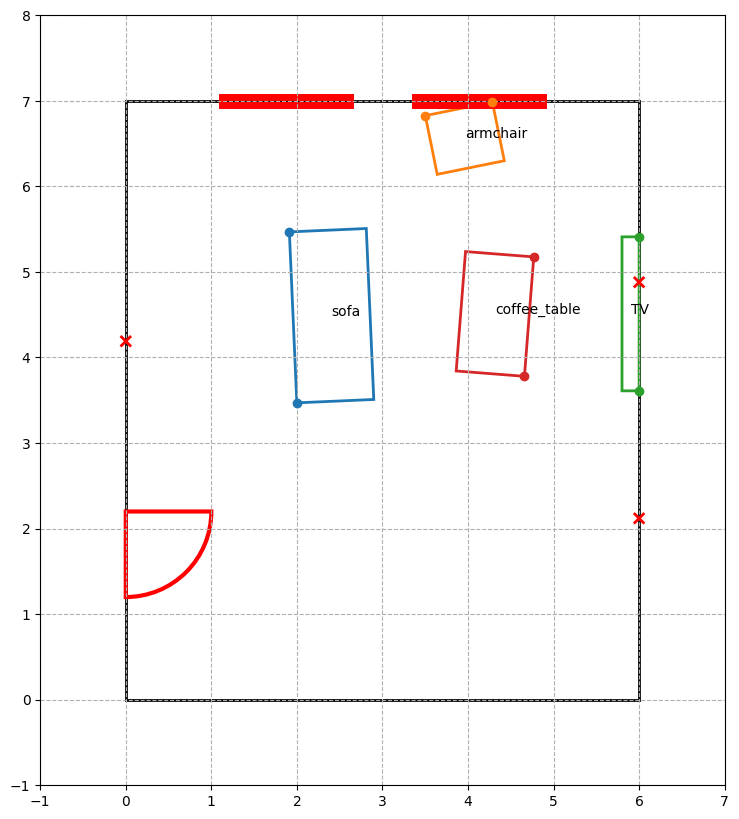

In [10]:
living_room = create_room(6, 7)
create_fixed_object(living_room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(living_room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(living_room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(living_room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(living_room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(living_room, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(living_room, 'sofa', 2, 0.9, 'living', 0)
create_moving_object(living_room, 'armchair', 0.8, 0.7, 'living', 1)
create_moving_object(living_room, 'TV', 1.8, 0.2, 'living', 2)
create_moving_object(living_room, 'coffee_table', 1.4, 0.8, 'living', 3)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_next_to_wall(positions, room, 2, 'back')  # TV
    output += ind_central(positions, room, 2)
    output += ind_close_to_fixed_object(positions, room, 2, 'socket', side = 'back')

    output += p_facing(positions, room, 0, 2, both = True)
    output += p_facing(positions, room, 1, 3)
    output += p_facing(positions, room, 0, 3)
    output += p_infront(positions, room, 3, 2)
    output += p_infront(positions, room, 3, 0)
    output += p_perpendicular_aligned(positions, room, 0, 1, center_object_index=3)

    output += ind_accessible(positions, room, 3, ['front', 'left', 'right', 'back'])

    output += 3*ind_aligned(positions, room)
    output += 5*ind_no_overlap(positions, room)
    output += 5*ind_in_bounds(positions, room)

    return output

bounds = Bounds([0] * 3 * len(living_room.moving_objects), [living_room.width, living_room.length, 2*np.pi] * len(living_room.moving_objects))
options = {'maxiter': 500, 'ftol': 1e-6}

max_iters = 100
min_fun = np.Inf
iters = 0
while min_fun > 0.3:
    positions = np.zeros(3*len(living_room.moving_objects))
    for i in range(len(living_room.moving_objects)): 
        positions[3*i] = np.random.uniform(0, living_room.width)
        positions[3*i + 1] = np.random.uniform(0, living_room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(optimize_primary_objects, positions, args = (living_room), method = 'SLSQP', options = options)

    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if iters == max_iters: 
        print("Max number of iterations reached.")
        break 
    if iters%10 == 0: 
        print(iters, best_res.fun)
    iters += 1


print(iters, best_res.fun)
for i in range(len(living_room.moving_objects)): 
    living_room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 

living_room.draw() 

In [41]:
def p_surround(positions, room, central_object_index, object_indices):
    """ The function p_surroudn ensures that central_object is surrounded by all the objects in object_indices.
        This would be used for chairs around a dining table.

        Args:
        positions: list of floats, x, y, theta values for all objects in the room
        room: rectangular Room object
        central_object_index: int, Object object
        object_indices: list of ints, indices of Object objects
    """

    val = 0
    center_x, center_y = positions[3*central_object_index:3*central_object_index + 2]

    pos = np.array(positions).reshape(-1, 3)
    pos = pos[object_indices, :]
    thetas = pos[:, 2] ## all thetas should add up to a multiple of pi
    val += (np.sum(thetas) - np.round(np.sum(thetas)/np.pi)*np.pi)**2

    center_of_mass = np.mean(pos[:, :2], axis = 0)
    val += 2 * ((center_of_mass[0] - center_x)**2 + (center_of_mass[1] - center_y)**2)# center of mass of all the objects
    all_objects_distances_to_sides = []
    for i in range(len(object_indices)):
        #val += p_facing(positions, room, object_indices[i], central_object_index)
        val += p_next_to(positions, room, object_indices[i], central_object_index, side1 = 'front')
        distances_to_sides = [p_next_to(positions, room, object_indices[i], central_object_index, side1 = 'front', side2 = j) for j in ['front', 'back', 'left', 'right']]
        all_objects_distances_to_sides += [min(distances_to_sides)]
    


    all_objects_distances_to_sides = np.array(all_objects_distances_to_sides)
    average_distance = np.mean(all_objects_distances_to_sides)
    for j in range(len(object_indices)):
        val += np.sum((all_objects_distances_to_sides[j] - average_distance)**2)

    return val


No region with this name is in the room.
Region not found.
0 0.0008874204810539403
1 0.0008874204810539403 Optimization terminated successfully


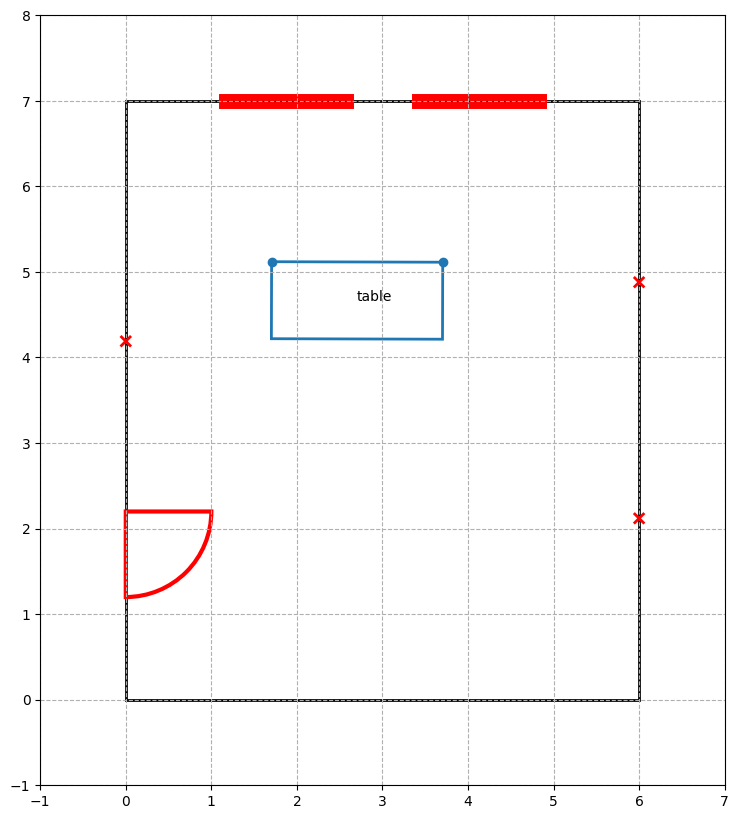

0.0008874204810539403


In [63]:
## Dining Room 

dining_room = create_room(6, 7)
create_fixed_object(dining_room, 'window', 1.5, 0.1, 'north', position = 0.25)
create_fixed_object(dining_room, 'window', 1.5, 0.1, 'north', position = 0.75)
create_fixed_object(dining_room, 'door', 1, 0.1, 'west', position = 0.2)
create_fixed_object(dining_room, 'socket', 0.1, 0.05, 'west', position = 0.6)
create_fixed_object(dining_room, 'socket', 0.1, 0.05, 'east', position = 0.3)
create_fixed_object(dining_room, 'socket', 0.1, 0.05, 'east', position = 0.7)

create_moving_object(dining_room, 'table', 2, 0.9, 'dining', 0)
# for i in range(6):
#     create_moving_object(dining_room, 'chair', 0.6, 0.5, 'dining', i + 1)

def optimize_primary_objects(positions, room): 
    
    output = 0
    output += ind_central(positions, room, 0, both = True) # dining table 
    #output += p_surround(positions, room, 0, [i + 1 for i in range(6)]) # chairs around dining table
    # for i in range(1,  7): 
    #     output += p_next_to(positions, room, i, 0, side1 = 'front')

    output += ind_aligned(positions, room)
    output += 5*ind_in_bounds(positions, room)
    output += 5*ind_no_overlap(positions, room)

    return output

bounds = Bounds([0] * 3 * len(dining_room.moving_objects), [dining_room.width, dining_room.length, 2*np.pi] * len(dining_room.moving_objects))
options = {'maxiter': 400, 'ftol': 1e-6}


max_iters = 30
min_fun = np.Inf
iters = 0
while min_fun > 1e-2:
    positions = np.zeros(3*len(dining_room.moving_objects))
    for i in range(len(dining_room.moving_objects)): 
        positions[3*i] = np.random.uniform(0, dining_room.width)
        positions[3*i + 1] = np.random.uniform(0, dining_room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(optimize_primary_objects, positions, args = (dining_room), method = 'SLSQP', options = options)
    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if iters == max_iters: 
        print("Max number of iterations reached.")
        break 

    if iters % 10 == 0: 
        print(iters, best_res.fun)

    iters += 1

print(iters, res.fun, res.message)
    
for i in range(len(dining_room.moving_objects)): 
    dining_room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 

dining_room.draw() 
print(best_res.fun)

No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
No region with this name is in the room.
Region not found.
0 3.4317169046715343
10 0.4291742580442152
Max number of iterations reached.
15 2.694138237634026 Optimization terminated successfully


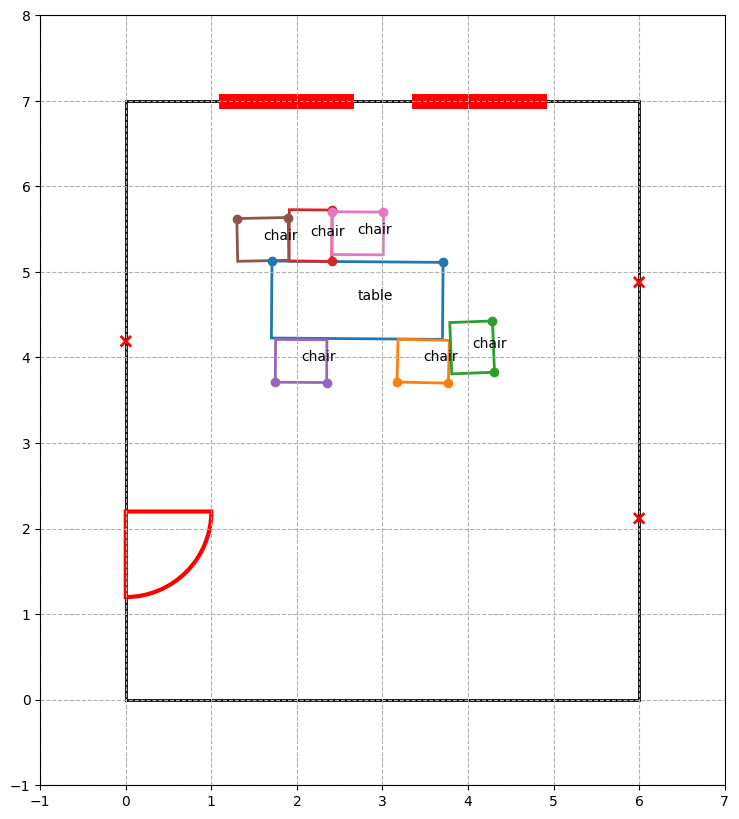

0.4291742580442152


In [64]:
for i in range(6):
    create_moving_object(dining_room, 'chair', 0.6, 0.5, 'dining', i + 1)

def optimize_primary_objects(positions, room): 

    output = 0
    # for i in range(1,  7): 
    #     output += p_next_to(positions, room, i, 0, side1 = 'front')

    output += p_surround(positions, room, 0, [i + 1 for i in range(6)]) # chairs around dining table

    output += 100*np.linalg.norm(positions[:3] - dining_room.moving_objects[0].position)**2
    output += 3*ind_aligned(positions, room)
    output += 5*ind_in_bounds(positions, room)
    output += 5*ind_no_overlap(positions, room)

    return output

bounds = Bounds([0] * 3 * len(dining_room.moving_objects), [dining_room.width, dining_room.length, 2*np.pi] * len(dining_room.moving_objects))
options = {'maxiter': 400, 'ftol': 1e-6}


max_iters = 15
min_fun = np.Inf
iters = 0
while min_fun > 1e-2:
    positions = np.zeros(3*len(dining_room.moving_objects)) 
    positions[:3] = dining_room.fixed_objects[-1].position
    for i in range(1, len(dining_room.moving_objects)): 
        positions[3*i] = np.random.uniform(0, dining_room.width)
        positions[3*i + 1] = np.random.uniform(0, dining_room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(optimize_primary_objects, positions, args = (dining_room), method = 'SLSQP', options = options)
    if res.fun < min_fun:
        min_fun = res.fun
        best_res = res
    if iters == max_iters: 
        print("Max number of iterations reached.")
        break 

    if iters % 10 == 0: 
        print(iters, best_res.fun)

    iters += 1

print(iters, res.fun, res.message)
    
for i in range(len(dining_room.moving_objects)): 
    dining_room.moving_objects[i].position = best_res.x[3*i:3*i + 3] 

dining_room.draw() 
print(best_res.fun)